# Coldest Tmin and Warmest TMax of the year Analysis

ERA5

1979 - 2024

Coldest Tmin and Warmest TMax are computed from 5day running windows

In [113]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import glob
import utils
import matplotlib.colors as colors
import cmaps
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
import functions_utils

In [114]:
import warnings
warnings.filterwarnings('ignore')

In [115]:
datadir='/Projects/RAPrototype/ERA5'
plotdir='/home/ghervieux/SCRIPTS/GEV/PLOTS'

In [116]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [117]:
yearb=1979
yeare=2024
model='era5_5droll'

# Read FILES

In [118]:
lon_min=235;lon_max=293
lat_min=22;lat_max=50

In [119]:
def preprocess(ds):
    return ds.\
            sel(lon=slice(lon_min,lon_max)).\
            sel(lat=slice(lat_max,lat_min))

In [120]:
dsmask = xr.open_dataset('/Projects/era5/timeInvariant/lsmask.era5.1.nc')
dsmask = preprocess(dsmask)
dsmask = dsmask.sortby('lat')
dsmask = dsmask.isel(time=0,drop=True)

# Read Coldest Day ERA5

In [121]:
temp_var='coldest_tmin'
year=np.arange(yearb,yeare+1,1)

In [122]:
files=[f'{datadir}/Coldest_Day.era5.{iyear}_5droll.nc' for iyear in year]
dstmin = xr.open_mfdataset(files,combine='nested', concat_dim='year', preprocess=preprocess)
dstmin = dstmin.sortby('lat')
dstmin =dstmin.load()
dstmin['year'] = year.astype('int64')
Tmin = (dstmin['coldest_tmin'] - 273.15) * 9/5 + 32
Tmin = Tmin.where(dsmask['lsmask']==1)
units='$\degree$F'
trend_tmin = functions_utils.trend_dim(Tmin,'year')


# Read Hottest Day ERA5

In [123]:
temp_var='hottest_tmax'
year=np.arange(yearb,yeare+1,1)

In [124]:
files=[f'{datadir}/Hottest_Day.era5.{iyear}_5droll.nc' for iyear in year]
dstmax = xr.open_mfdataset(files,combine='nested', concat_dim='year', preprocess=preprocess)
dstmax = dstmax.sortby('lat')
dstmax = dstmax.load()
dstmax['year'] = year.astype('int64')
Tmax = (dstmax['hottest_tmax'] - 273.15) * 9/5 + 32
Tmax = Tmax.where(dsmask['lsmask']==1)
trend_tmax = functions_utils.trend_dim(Tmax,'year')


# Read Topography

In [125]:
dshgt = xr.open_dataset('/Projects/era5/timeInvariant/hgt.sfc.era5.1.nc')
dshgt = preprocess(dshgt) 
dshgt = dshgt.sortby('lat')
dshgt = dshgt.isel(time=0, drop=True)

# Timeseries

In [126]:
print(trend_tmin['polyfit_coefficients'].sel(degree=1).min().data.item(),trend_tmin['polyfit_coefficients'].sel(degree=1).max().data.item())

-0.11039715383731503 0.40831686496881786


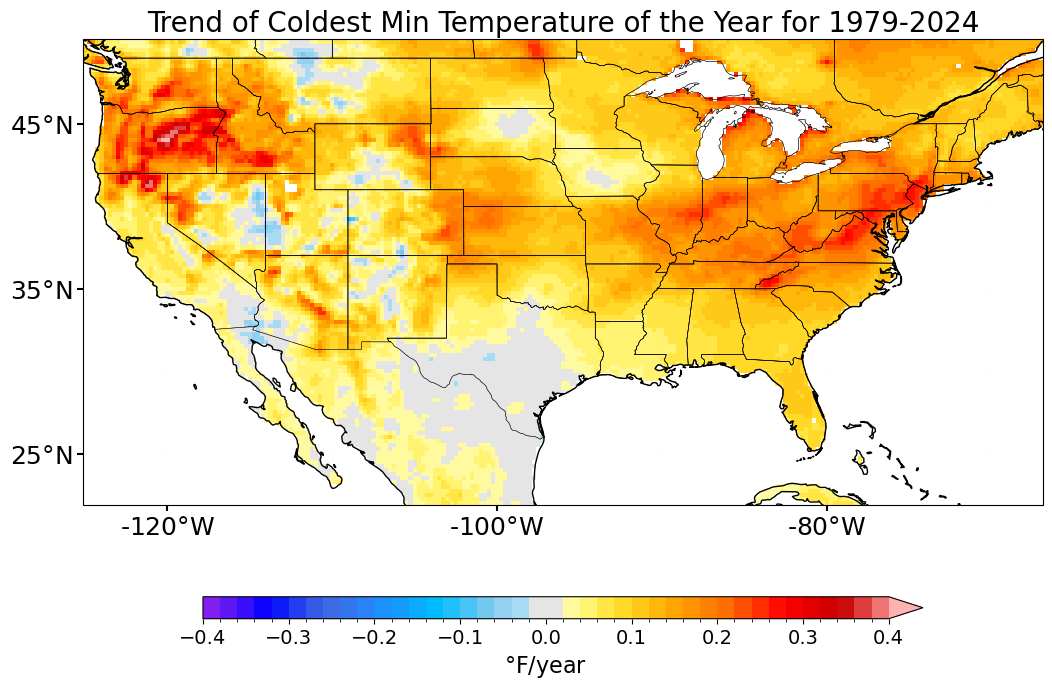

In [127]:
proj=ccrs.PlateCarree()

clevs = np.arange(-0.4,0.42,0.02)
n = len(clevs)
cmap = cmaps.ncl_default.to_seg(N=n)
colors = [cmap(i) for i in range(0,n)]
colors[n // 2 -1 ] = [0.8, 0.8, 0.8, 0.5] # set to grey
colors[n // 2] = [0.8, 0.8, 0.8, 0.5]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)
cc=trend_tmin['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax,colors=colors,levels=clevs,add_colorbar=False)

####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Trend of Coldest Min Temperature of the Year for {yearb}-{yeare}',fontsize=20)  
plt.suptitle('')  
outfile=f'PLOTS/Trend_Coldest_Tmin_{yearb}_{yeare}_CONUS_wStations_{model}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

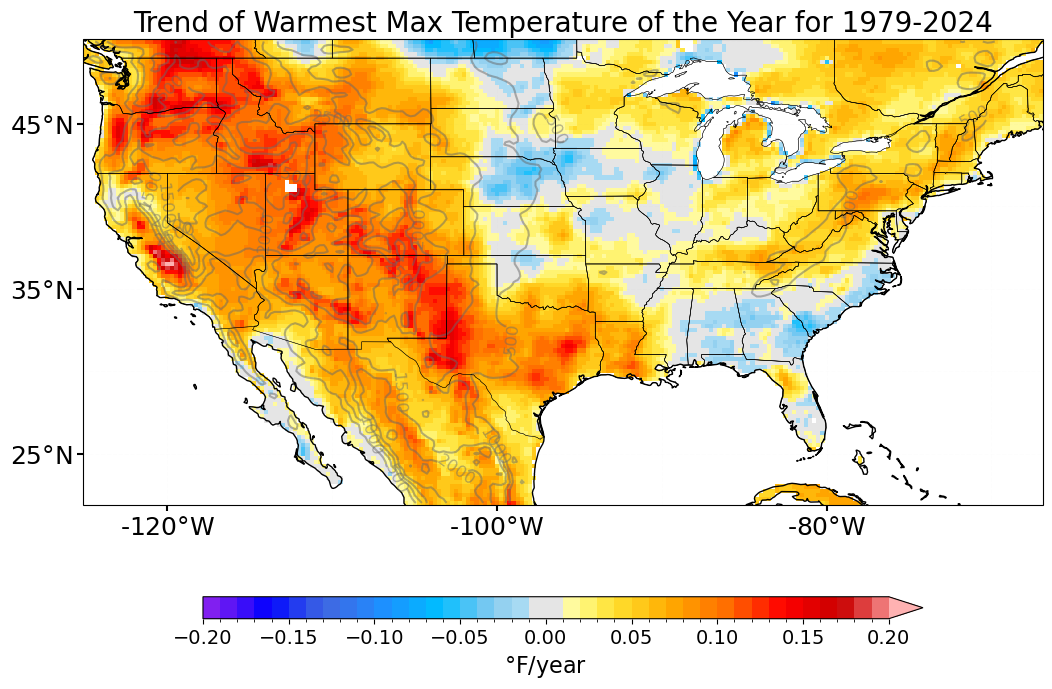

In [128]:
clevs = np.arange(-0.2,0.21,0.01)
n = len(clevs)
cmap = cmaps.ncl_default.to_seg(N=n)
colors = [cmap(i) for i in range(0,n)]
colors[n // 2 -1 ] = [0.8, 0.8, 0.8, 0.5] # set to grey
colors[n // 2] = [0.8, 0.8, 0.8, 0.5]
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)
cc=trend_tmax['polyfit_coefficients'].sel(degree=1).plot.pcolormesh(ax=ax,colors=colors,levels=clevs,add_colorbar=False)
cs = ax.contour(dshgt['lon'],dshgt['lat'],dshgt['hgt'],levels=np.arange(500,5500,500),colors='dimgrey',alpha=0.5)
ax.clabel(cs, inline=True, fmt='%d', fontsize=12)

####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}/year',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Trend of Warmest Max Temperature of the Year for {yearb}-{yeare}',fontsize=20)  
plt.suptitle('')   
outfile=f'PLOTS/Trend_Warmest_Tmax_{yearb}_{yeare}_CONUS_wStations_{model}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Regression onto GLOST

In [129]:
fileGLOST = f'/data/ghervieux/AFI/NOAA_GLOST_anomaly.csv'
df_glost=pd.read_csv(fileGLOST,skiprows=4)
df_glost['Year']=pd.to_datetime(df_glost['Year'], format='%Y%m')
ds_glost=df_glost.set_index(['Year']).to_xarray()
# Smooth
sm_x, smooth_glost = sm_lowess(ds_glost['Anomaly'], ds_glost['Year'],  frac=(30*12)/len(ds_glost['Year']), 
                           it=5, return_sorted = True).T
smooth_glost=xr.DataArray(smooth_glost,dims=['time'],coords={'time':ds_glost['Year'].data}) 
# Annual
ann_glost=functions_utils.ann_mean(smooth_glost)
ann_glost=ann_glost.rename({'year':'time'})
ann_glost = ann_glost.sel(time=slice(yearb,yeare))
ann_glost = ann_glost.rename({'time':'year'})
yeare=ann_glost.year[-1].data.item()

# Correlation onto GLOST

In [130]:
cor_tmin = functions_utils.rvalue_array(Tmin.sel(year=slice(yearb,yeare)),ann_glost,'year')
cor_tmax = functions_utils.rvalue_array(Tmax.sel(year=slice(yearb,yeare)),ann_glost,'year')

pvalue_tmin = functions_utils.pvalue_array(Tmin.sel(year=slice(yearb,yeare)),ann_glost,'year')
pvalue_tmax = functions_utils.pvalue_array(Tmax.sel(year=slice(yearb,yeare)),ann_glost,'year')

In [131]:
print(cor_tmin.min().values,cor_tmin.max().values)
print(cor_tmax.min().values,cor_tmax.max().values)

-0.2154903957704385 0.6807613939074271
-0.44109743451496036 0.7653662382583247


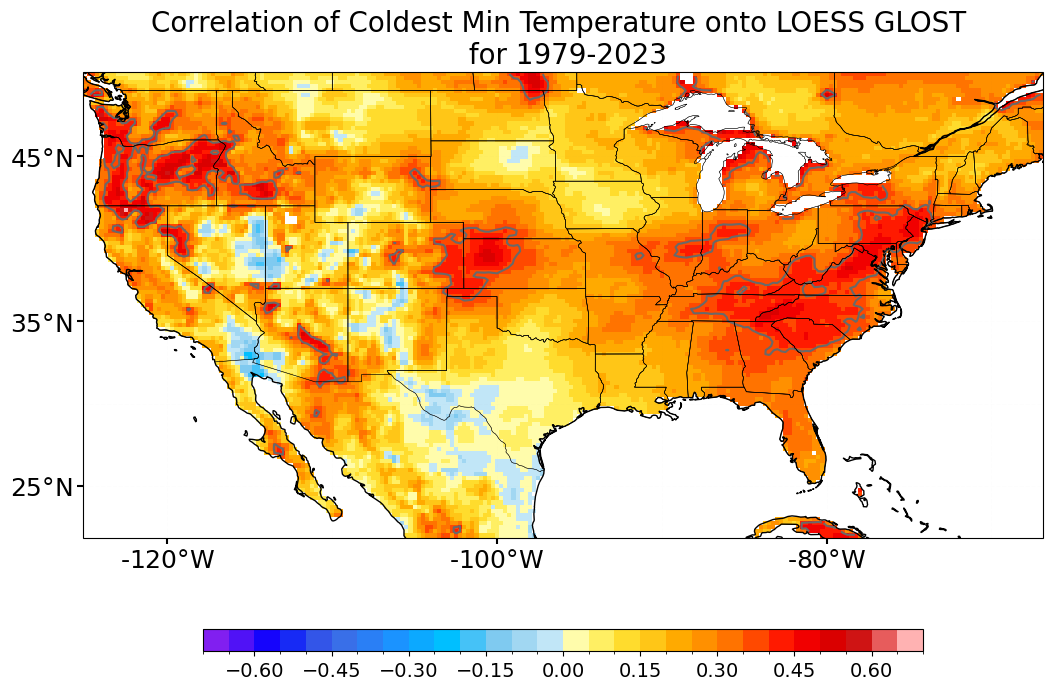

In [132]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

clevs = np.arange(-0.7,.75,0.05)
idlat,idlon=np.where(pvalue_tmin < 0.01)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)

cc=cor_tmin.plot.pcolormesh(ax=ax,cmap=cmap,levels=clevs,add_colorbar=False)
ax.contour(pvalue_tmin['lon'],pvalue_tmin['lat'],pvalue_tmin,levels=[0,0.01],colors='dimgrey')

####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label='',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()

ax.set_title(f'Correlation of Coldest Min Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Correlation_Coldest_tmin_GLOST_{yearb}_{yeare}_CONUS_{model}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Grey dots mark significance at 90%.
Grey contours mark topography.

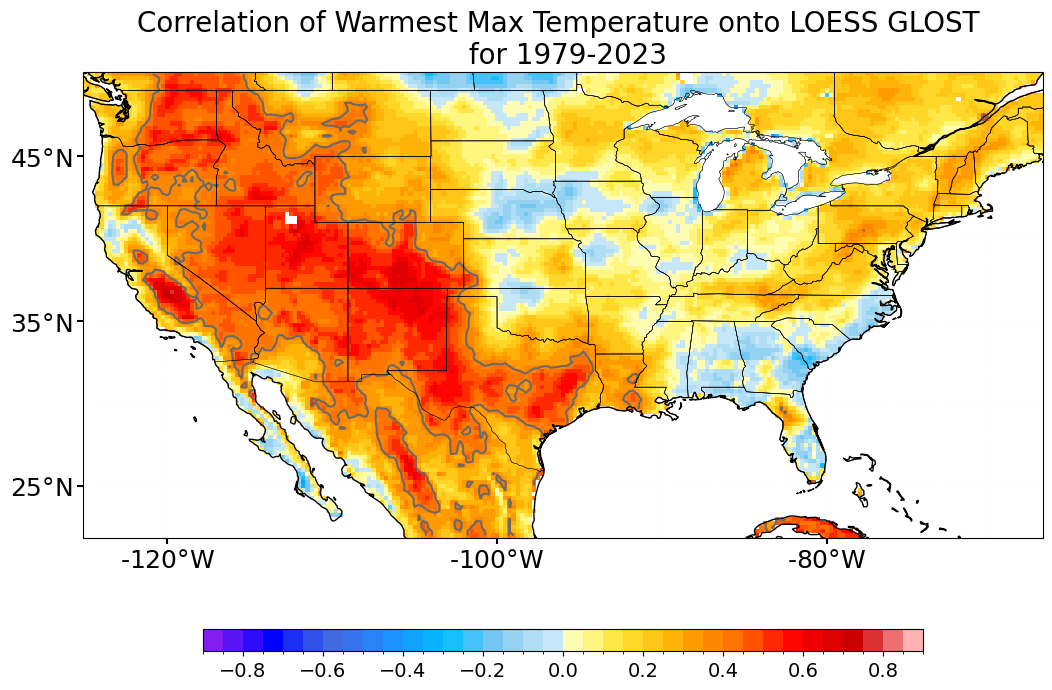

In [133]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

clevs = np.arange(-0.9,.95,0.05)
idlat,idlon=np.where(pvalue_tmax < 0.01)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,11),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,left=0.1, right=0.9)

cc=cor_tmax.plot.pcolormesh(ax=ax,cmap=cmap,levels=clevs,add_colorbar=False)
ax.contour(pvalue_tmax['lon'],pvalue_tmax['lat'],pvalue_tmax,levels=[0,0.01],colors='dimgrey')

####
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label='',fontsize=16)

ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
ax.coastlines()
ax.set_title(f'Correlation of Warmest Max Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Correlation_Warmest_tmax_GLOST_{yearb}_{yeare}_CONUS_{model}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Grey contours mark significance at 90%.
